# Step 1: Build ASR pipeline
## Data preprocessing

In [1]:
from collections import defaultdict
import numpy as np
from pipelines.evaluation import get_or_filter_from_list, setup_database
import json

error_database_size = 0.5
filters = {
    "train": ["train"],
    "dev": ["train", "dev"],
    "test": ["train", "dev", "test"]
}
seed = 42
error_document_id_filter = defaultdict(list)
rng = np.random.default_rng(seed=seed)

error_document_store, error_search = setup_database(
    "ann_10_gazetteers_error_dataset_868514705", "ann", 10)

with open("/home/loebbert/projects/thesis/evaluations/false_positives.json", "r", encoding="utf-8") as file:
    false_positives = json.load(file)

for part in filters:
    current_filter = get_or_filter_from_list("dataset", filters[part])
    current_filter["$not"] = {  # type: ignore
        "doc_id": [doc_id for doc_id in false_positives[part]]
    }
    doc_count = error_document_store.get_document_count(
        current_filter)  # type: ignore
    filter_mask = rng.choice(doc_count,
                                int(doc_count * error_database_size),
                                replace=False).tolist()
    docs = error_document_store.get_all_documents(
        filters=current_filter)  # type: ignore
    for search_mask, doc in enumerate(docs):
        if search_mask in filter_mask and doc.id not in error_document_id_filter[
                part]:
            error_document_id_filter[part].append(doc.id)


/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
for key, values in error_document_id_filter.items():
    print(key, len(values))

train 706
dev 1040
test 1498


In [5]:
doc = {
    "tokens": [
        "@paulwalk", "It", "'s", "the", "view", "from", "where", "I", "'m",
        "living", "for", "two", "weeks", ".", "Empire", "State", "Building",
        "=", "ESB", ".", "Pretty", "bad", "storm", "here", "last", "evening",
        "."
    ],
    "extended": [
        "@paulwalk", "It", "'s", "the", "view", "from", "where", "I", "'m",
        "living", "for", "two", "weeks", ".", "Empire", "State", "Building",
        "=", "ESB", ".", "Pretty", "bad", "storm", "here", "last", "evening",
        "."
    ],
    "entities": [{
        "type": "location",
        "start": 14,
        "end": 17
    }, {
        "type": "location",
        "start": 18,
        "end": 19
    }],
    "doc_id":
    "wnut_train_0"
}
sentence = " ".join(doc["tokens"])

In [6]:
results = error_search.run(query=sentence,
                           params={
                               "filters": {
                                   "$and": {
                                       "$not": {
                                           "doc_id": [doc["doc_id"]],
                                           "content": sentence,
                                           "_id":
                                           error_document_id_filter["train"]
                                       },
                                       **{
                                           "$or": [{
                                               "dataset": ["train"]
                                           }]
                                       }
                                   }
                               }
                           })


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


In [21]:
docs = error_document_store.get_all_documents(
    filters={
        "$and": {
            "$not": {
                "doc_id": [doc["doc_id"]],
                "content": sentence,
                "_id": error_document_id_filter["dev"]
            },
            **get_or_filter_from_list("dataset", filters["dev"])
        }
    })


In [12]:
error_document_store.get_document_count()

3190

In [22]:
len(docs)

1233

In [8]:
results["documents"][0]

<Document: {'content': 'NYC', 'content_type': 'text', 'score': 0.5011589979241876, 'meta': {'data_type': 'gazetteers', 'type': 'location', 'doc_id': ['wnut_train_442', 'wnut_train_473', 'wnut_train_1830', 'wnut_train_2098', 'wnut_train_2248', 'wnut_train_2478'], 'dataset': ['train']}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '3e40989e0035845aed63ad3b9989e9ac'}>

In [5]:
from data_preparation.wnut import bio_to_json

bio_to_json("science",
            "/home/loebbert/projects/thesis/data/crossner/science/train.txt",
            "/home/loebbert/projects/thesis/data/crossner/science/dev.txt",
            "/home/loebbert/projects/thesis/data/crossner/science/test.txt")


In [4]:
from data_preparation.conll03 import conll03_to_json

conll03_to_json("data/conll03/train.txt", "data/conll03/valid.txt",
                "data/conll03/test.txt")


In [2]:
types['entities']

{'location': {'short': 'location'},
 'group': {'short': 'group'},
 'corporation': {'short': 'corporation'},
 'person': {'short': 'person'},
 'creative-work': {'short': 'creative-work'},
 'product': {'short': 'product'}}

In [7]:
test[204]

{'tokens': ['For',
  'more',
  'info',
  'about',
  'this',
  'and',
  'local',
  'views',
  'on',
  'the',
  'matter',
  'check',
  'out',
  'where',
  'OP',
  'took',
  'this',
  'from',
  '.'],
 'extended': ['For',
  'more',
  'info',
  'about',
  'this',
  'and',
  'local',
  'views',
  'on',
  'the',
  'matter',
  'check',
  'out',
  'where',
  'OP',
  'took',
  'this',
  'from',
  '.'],
 'entities': [Entity(type='creative-work', start=6, end=8)]}

In [4]:
from data_preprocessing.tokenize import tokenize_json
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small", model_max_length=4096)

tokenize_json(tokenizer,
              "datasets/wnut/wnut17train.json",
              "datasets/wnut/emerging.dev.json",
              "datasets/wnut/emerging.test.json",
              "datasets/wnut/wnut_types.json")

/Users/robinloebbert/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from data_preprocessing.tokenize import tokenize_json
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small", model_max_length=4096)

tokenize_json(tokenizer, "datasets/conll03/conll03_train.json",
              "datasets/conll03/conll03_dev.json",
              "datasets/conll03/conll03_test.json",
              "datasets/conll03/conll03_types.json")

/home/loebbert/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


conll03_train: dropped 5 inst_ids: 8884 10279 13068 13234 13672
conll03_dev: dropped 8 inst_ids: 1055 2184 2185 2594 2595 2616 2617 2903
conll03_test: dropped 8 inst_ids: 33 46 47 202 203 1841 3198 3199


In [ ]:
# labels can have multiple values concatenated via commas!

In [1]:
from data_preprocessing.tensorize import NERDataProcessor
from data_preprocessing.tokenize import MENTION_START, MENTION_END
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small", model_max_length=4096)
tokenizer.add_tokens(MENTION_START)
tokenizer.add_tokens(MENTION_END)

config = {
    "mention_start_token": MENTION_START,
    "mention_end_token": MENTION_END
}

processor = NERDataProcessor(config, tokenizer,
                             "datasets/wnut/wnut17train.t5-small.jsonlines",
                             "datasets/wnut/emerging.dev.t5-small.jsonlines",
                             "datasets/wnut/emerging.test.t5-small.jsonlines",
                             "datasets/wnut/wnut_types.json")

/home/loebbert/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
processor.get_cache_path()

'datasets/wnut/cached.tensors.t5-small.bin'

In [2]:
train, dev, test = processor.get_tensor_samples()

In [3]:
processor.stored_info["example"]["emerging.test_22"]

{'doc_id': 'emerging.test_22',
 'sentence': ['▁Rep',
  'ly',
  'ing',
  '▁to',
  '▁another',
  '▁question',
  ',',
  '▁B',
  'ham',
  're',
  '▁said',
  '▁the',
  '▁jaw',
  'ans',
  '▁deployed',
  '▁at',
  '▁places',
  '▁such',
  '▁as',
  '▁Si',
  'a',
  'chen',
  '▁Gla',
  'cier',
  '▁are',
  '▁provided',
  '▁with',
  '▁the',
  '▁best',
  '-',
  'quality',
  '▁winter',
  '▁clothing',
  '.',
  '</s>'],
 'input_sentence': ['▁named',
  '▁entity',
  '▁recognition',
  ':',
  '▁Rep',
  'ly',
  'ing',
  '▁to',
  '▁another',
  '▁question',
  ',',
  '▁B',
  'ham',
  're',
  '▁said',
  '▁the',
  '▁jaw',
  'ans',
  '▁deployed',
  '▁at',
  '▁places',
  '▁such',
  '▁as',
  '▁Si',
  'a',
  'chen',
  '▁Gla',
  'cier',
  '▁are',
  '▁provided',
  '▁with',
  '▁the',
  '▁best',
  '-',
  'quality',
  '▁winter',
  '▁clothing',
  '.',
  '</s>'],
 'target_sentence': ['▁Rep',
  'ly',
  'ing',
  '▁to',
  '▁another',
  '▁question',
  ',',
  '<m>',
  '<m>',
  '▁B',
  'ham',
  're',
  '</m>',
  '</m>',
  '▁said'

In [4]:
import pickle

test_multiple = None
for (doc_key, subtoken_map, sample) in test.data:
    if doc_key == "emerging.test_22":
        test_multiple = (doc_key, subtoken_map, sample)
        break
with open("tests/data/wnut_nested_batch_1.pkl", "wb") as file:
    pickle.dump(test_multiple, file)

with open("tests/data/wnut_nested_batch_10.pkl", "wb") as file:
    res = [test_multiple, *test.data[:9]]
    print(len(res))
    pickle.dump(res, file)

with open("tests/data/wnut_batch_1.pkl", "wb") as file:
    pickle.dump(train.data[0], file)

with open("tests/data/wnut_batch_10.pkl", "wb") as file:
    pickle.dump(train.data[:10], file)

10


In [2]:
5/3, 5//3

(1.6666666666666667, 1)

In [5]:
from data_preprocessing.tensorize import ner_collate_fn
import pickle

with open("tests/data/wnut_batch_10.pkl", "rb") as file:
            data_point = pickle.load(file)
(doc_keys, subtoken_maps, batch) = ner_collate_fn(data_point)
assert len(subtoken_maps) == 10

In [6]:
subtoken_maps

([0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  8,
  8,
  9,
  9,
  9,
  10,
  11,
  12,
  13,
  13,
  13,
  13,
  13,
  14,
  14,
  15,
  16,
  17,
  18,
  18,
  18,
  18,
  18,
  19,
  19,
  19,
  19,
  19,
  19,
  20,
  20,
  20,
  20,
  21,
  22,
  22,
  22,
  22,
  23,
  23,
  23,
  23,
  23,
  24,
  24,
  24,
  24,
  25,
  26,
  26,
  27,
  28,
  29,
  30],
 [0,
  0,
  1,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  5,
  6,
  6,
  7,
  7,
  7,
  8,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  10,
  11,
  12,
  12,
  13,
  13,
  14,
  14,
  14,
  15,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  17,
  18,
  19,
  19,
  20,
  21,
  22,
  22,
  22,
  23,
  24,
  24,
  25,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  31,
  32,
  32,
  33,
  33,
  33,
  33,
  33,
  33,
  33,
  33,
  34,
  34,
  34,
  34,
  34,
  35],
 [0,
  0,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  3,
  4,
  5,

In [6]:
from transformers import T5Tokenizer, T5Model

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5Model.from_pretrained("t5-small")

input_ids = tokenizer(
    "Studies have been shown that owning a dog is good for you", return_tensors="pt"
).input_ids  # Batch size 1
decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1

# forward pass
outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
last_hidden_states = outputs.last_hidden_state

/Users/robinloebbert/opt/miniconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [1]:
import torch

torch.__version__

'2.0.0'

In [9]:
import os
"/" + os.path.join(*os.getcwd().split(os.path.sep)[:-1])

'/home/loebbert/projects'

In [1]:
from models.metrics import F1ASP

metric = F1ASP()

/home/loebbert/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
metric.update([(2, 3, 5)], [])
metric.update([], [])

In [28]:
metric.compute()

0.6530612707138062

In [1]:
from data.statistics_json import create_dataset_stats

asp_inputs, asp_entities = create_dataset_stats("data/conll03/asp/conll03_train.json",
                     "data/conll03/asp/conll03_dev.json",
                     "data/conll03/asp/conll03_test.json")


In [2]:
asp_inputs, asp_entities

(       Sentences  Tokens  Entities
 train       8564  203621     23484
 dev         2176   51362      5938
 test        1948   46435      5640,
        Total     LOC    MISC     ORG     PER
 train  23484  7132.0  3438.0  6319.0  6595.0
 dev     5938  1834.0   922.0  1341.0  1841.0
 test    5640  1663.0   702.0  1659.0  1616.0)

In [8]:
entitiy = asp_entities["Total"].copy()
entitiy.name = "asdf"
entitiy

train    23484
dev       5938
test      5640
Name: asdf, dtype: int64

In [9]:
entitiy2 = asp_entities["Total"].copy()
entitiy2.name = "asdf2"
entitiy2

train    23484
dev       5938
test      5640
Name: asdf2, dtype: int64

In [10]:
entitiy

train    23484
dev       5938
test      5640
Name: asdf, dtype: int64

In [11]:
import pandas as pd

pd.concat([entitiy, entitiy2], axis=1)

,asdf,asdf2
train,23484,23484
dev,5938,5938
test,5640,5640


In [25]:
stats_asp["train_entities"].loc["sum"].to_dict()

{'ORG': 6319.0,
 'entity_len': 34018.0,
 'MISC': 3438.0,
 'PER': 6595.0,
 'LOC': 7132.0}

In [17]:
from data.statistics_json import create_dataset_stats

stats_mine = create_dataset_stats("data/conll03/mine/conll03_train.json",
                                 "data/conll03/mine/conll03_dev.json",
                                 "data/conll03/mine/conll03_test.json")
stats_mine["test_inputs"]

,tokens_len,tokens_sent_count,extended_len,extended_sent_count,entities_count
sum,51362.000000,3472.000000,51362.000000,3472.000000,5938.000000
count,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000
mean,15.803692,1.068308,15.803692,1.068308,1.827077
std,12.603389,0.252312,12.603389,0.252312,1.777810
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,7.000000,1.000000,7.000000,1.000000,1.000000
50%,11.000000,1.000000,11.000000,1.000000,1.000000
75%,24.000000,1.000000,24.000000,1.000000,2.000000
90%,34.000000,1.000000,34.000000,1.000000,4.000000
max,109.000000,2.000000,109.000000,2.000000,20.000000


In [28]:
stats_mine["test_entities"]

,ORG,entity_len,MISC,PER,LOC
sum,1656.0,8087.000000,693.0,1617.0,1662.0
count,1656.0,5628.000000,693.0,1617.0,1662.0
mean,1.0,1.436923,1.0,1.0,1.0
std,0.0,0.655608,0.0,0.0,0.0
min,1.0,1.000000,1.0,1.0,1.0
25%,1.0,1.000000,1.0,1.0,1.0
50%,1.0,1.000000,1.0,1.0,1.0
75%,1.0,2.000000,1.0,1.0,1.0
90%,1.0,2.000000,1.0,1.0,1.0
max,1.0,6.000000,1.0,1.0,1.0


In [7]:
from data.statistics_json import create_dataset_stats

stats_hugginface = create_dataset_stats("data/conll03/huggingface/conll03_train.json",
                                  "data/conll03/huggingface/conll03_dev.json",
                                  "data/conll03/huggingface/conll03_test.json")
stats_hugginface["train_inputs"]

,tokens_len,tokens_sent_count,extended_len,extended_sent_count,entities_count
sum,203621.000000,14833.000000,203621.000000,14833.000000,23429.000000
count,14041.000000,14041.000000,14041.000000,14041.000000,14041.000000
mean,14.501887,1.056406,14.501887,1.056406,1.668613
std,11.602756,0.232251,11.602756,0.232251,1.527363
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,6.000000,1.000000,6.000000,1.000000,1.000000
50%,10.000000,1.000000,10.000000,1.000000,1.000000
75%,22.000000,1.000000,22.000000,1.000000,2.000000
90%,32.000000,1.000000,32.000000,1.000000,4.000000
max,113.000000,3.000000,113.000000,3.000000,20.000000


In [8]:
stats_hugginface["train_entities"]

,ORG,entity_len,MISC,PER,LOC
sum,6297.0,33954.000000,3403.0,6600.0,7129.0
count,6297.0,23429.000000,3403.0,6600.0,7129.0
mean,1.0,1.449230,1.0,1.0,1.0
std,0.0,0.698081,0.0,0.0,0.0
min,1.0,1.000000,1.0,1.0,1.0
25%,1.0,1.000000,1.0,1.0,1.0
50%,1.0,1.000000,1.0,1.0,1.0
75%,1.0,2.000000,1.0,1.0,1.0
90%,1.0,2.000000,1.0,1.0,1.0
max,1.0,10.000000,1.0,1.0,1.0


In [12]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

/home/loebbert/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/loebbert/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 684.26it/s]


In [6]:
ner_tags = {
    'O': 0,
    'B-PER': 1,
    'I-PER': 2,
    'B-ORG': 3,
    'I-ORG': 4,
    'B-LOC': 5,
    'I-LOC': 6,
    'B-MISC': 7,
    'I-MISC': 8
}
reversed_ner_tags = {v: k for k, v in ner_tags.items()}

In [10]:
for part in dataset:
    with open("datasets/conll03/huggingface/"+part+".txt", "w", encoding="utf-8") as file:
        for item in dataset[part]:
            for line in ["\t".join([token, "x", "x", reversed_ner_tags[ner_tag_id]]) for token, ner_tag_id in zip(item["tokens"], item["ner_tags"])]:
                file.write(line + "\n")
            file.write("\n")

In [13]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")

/home/loebbert/miniconda3/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
tokenizer

In [5]:

import torch

input_ids = torch.ones(80)
indices = [15, 20, 45, 60]

tensors = torch.tensor_split(input_ids, indices)
for t in tensors:
    print(t.size())

torch.Size([15])
torch.Size([5])
torch.Size([25])
torch.Size([15])
torch.Size([20])


In [21]:
torch.cat(tensors).size()

torch.Size([80])

In [20]:
import numpy as np

dropout = 0.3
np.random.choice([0, 1], size=4, p=[dropout, 1-dropout])

array([1, 0, 0, 1])

In [37]:
import pickle as pkl

with open("/home/loebbert/projects/thesis/finetuning/sentences_result_3.pkl", "rb") as file:
    results = pkl.load(file)

res_df = results.get_dataframe()

Couldn't read config from 1 paths


In [41]:
res_df.sort_values(by=["val_f1"], ascending=False)[:7].T

,6,8,4,0,5,10,9
val_f1,0.763514,0.760839,0.7151,0.705544,0.699222,0.699084,0.694484
time_this_iter_s,156.800921,168.276965,96.0914,126.166562,99.639483,114.005274,144.391847
done,False,False,False,False,False,False,False
timesteps_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN
episodes_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN
training_iteration,10,10,10,10,10,10,10
trial_id,2ef43fcc,348ce964,2371d2fb,ca7ed2cc,3e72a6df,0ce1cc67,d4862515
experiment_id,fa045ffd58d44e999a58f60a835834a5,fa045ffd58d44e999a58f60a835834a5,fa045ffd58d44e999a58f60a835834a5,fa045ffd58d44e999a58f60a835834a5,fa045ffd58d44e999a58f60a835834a5,fa045ffd58d44e999a58f60a835834a5,fa045ffd58d44e999a58f60a835834a5
date,2023-04-24_20-32-58,2023-04-24_21-22-42,2023-04-24_19-48-39,2023-04-24_18-34-15,2023-04-24_20-06-07,2023-04-24_22-06-31,2023-04-24_21-47-03
timestamp,1682361178,1682364162,1682358519,1682354055,1682359567,1682366791,1682365623


In [14]:
res_df.sort_values(by=["val_f1"], ascending=False).index.values[:2].tolist()

[2, 0]

In [40]:
best_results = []
for i in res_df.sort_values(by=["val_f1"], ascending=False).index.values[:2].tolist():
    best_results.append(results[i].config)
best_results.reverse()
best_results

[{'asp_hidden_dim': 201,
  'asp_activation': 'gelu_fast',
  'task_learning_rate': 0.001427004141277835,
  'adam_weight_decay': 0.3047154488657352,
  'warmup_ratio': 0.9053807192033322,
  'search_algorithm': 'bm25',
  'search_topk': 8,
  'train_search_dropout': 0.1211443957902944,
  'plm_pretrained_name_or_path': 't5-base',
  'plm_tokenizer_name': 't5-small',
  'model_max_length': 4096,
  'mention_start_token': '<m>',
  'mention_end_token': '</m>',
  'asp_dropout_rate': 0.3,
  'asp_init_std': 0.02,
  'num_labels': 6,
  'max_nest_depth': 1,
  'beam_size': 1,
  'plm_learning_rate': 5e-05,
  'plm_scheduler': 'linear_with_warmup',
  'task_scheduler': 'linear_with_warmup',
  'adam_eps': 1e-08,
  'num_epochs': 40,
  'gradient_accumulation_steps': 1,
  'batch_size': 40,
  'train_len': 3394,
  'fused': True,
  'use_labels': True,
  'use_mentions': True,
  'prepend_search_results': False,
  'filter_exact_match': False,
  'filter_same_document': False,
  'search_data_type': 'sentences',
  'seed':

In [14]:
results[5].config

{'asp_hidden_dim': 355,
 'asp_dropout_rate': 0.3,
 'asp_init_std': 0.019999999999999976,
 'asp_activation': 'gelu_fast',
 'plm_learning_rate': 4.999999999999997e-05,
 'task_learning_rate': 0.0013868381781415849,
 'adam_eps': 9.999999999999984e-09,
 'adam_weight_decay': 0.1,
 'warmup_ratio': 0.6483865273543568,
 'use_labels': True,
 'use_mentions': True,
 'prepend_search_results': False,
 'filter_exact_match': False,
 'filter_same_document': False,
 'search_algorithm': 'bm25',
 'search_topk': 5,
 'train_search_dropout': 0.6317431305015401,
 'train_search_shuffle': False,
 'plm_pretrained_name_or_path': 't5-base',
 'plm_tokenizer_name': 't5-small',
 'model_max_length': 4096,
 'mention_start_token': '<m>',
 'mention_end_token': '</m>',
 'num_labels': 6,
 'max_nest_depth': 1,
 'beam_size': 1,
 'plm_scheduler': 'linear_with_warmup',
 'task_scheduler': 'linear_with_warmup',
 'num_epochs': 20,
 'gradient_accumulation_steps': 1,
 'batch_size': 40,
 'train_len': 3394,
 'fused': True,
 'search_d

In [1]:
from data_preparation.lowner import lowner_to_json

lowner_to_json(
    "/home/loebbert/projects/thesis/data/mlowner/en/train_lower.txt",
    "/home/loebbert/projects/thesis/data/mlowner/en/dev_lower.txt",
    "/home/loebbert/projects/thesis/data/mlowner/en/test_sub_lower.txt")


In [1]:
import nevergrad

sorted(nevergrad.optimizers.registry.keys())

['ASCMADEthird',
 'AdaptiveDiscreteOnePlusOne',
 'AlmostRotationInvariantDE',
 'AnisotropicAdaptiveDiscreteOnePlusOne',
 'AvgMetaRecenteringNoHull',
 'BO',
 'BOSplit',
 'BayesOptimBO',
 'CM',
 'CMA',
 'CMAbounded',
 'CMApara',
 'CMAsmall',
 'CMAstd',
 'CMAtuning',
 'CMandAS2',
 'CMandAS3',
 'CauchyLHSSearch',
 'CauchyOnePlusOne',
 'CauchyScrHammersleySearch',
 'ChainCMAPowell',
 'ChainDiagonalCMAPowell',
 'ChainMetaModelPowell',
 'ChainMetaModelSQP',
 'ChainNaiveTBPSACMAPowell',
 'ChainNaiveTBPSAPowell',
 'ChoiceBase',
 'CmaFmin2',
 'Cobyla',
 'DE',
 'DiagonalCMA',
 'DiscreteBSOOnePlusOne',
 'DiscreteDE',
 'DiscreteDoerrOnePlusOne',
 'DiscreteLenglerOnePlusOne',
 'DiscreteLenglerOnePlusOneT',
 'DiscreteOnePlusOne',
 'DiscreteOnePlusOneT',
 'DoubleFastGADiscreteOnePlusOne',
 'EDA',
 'ES',
 'FCMA',
 'GeneticDE',
 'HaltonSearch',
 'HaltonSearchPlusMiddlePoint',
 'HammersleySearch',
 'HammersleySearchPlusMiddlePoint',
 'HullAvgMetaRecentering',
 'HullAvgMetaTuneRecentering',
 'LHSSearch',


In [6]:
import torch
import torch.nn as nn

input1 = torch.randn(20, 100, 128)
input2 = torch.randn(20, 100, 128)
cos = nn.CosineSimilarity(dim=-1)
output = cos(input1, input2)
max_output = torch.max(output, dim=-1)

In [11]:
output.shape, max_output.values.shape, max_output.indices

(torch.Size([20, 100]),
 torch.Size([20]),
 tensor([33,  4, 98, 93, 96, 90, 90,  4, 86, 70, 73, 59,  7, 24, 19, 16, 74, 61,
         42, 52]))

In [18]:
max_output.values.cpu().numpy().tolist()

[0.19728688895702362,
 0.24605660140514374,
 0.2030540108680725,
 0.18328489363193512,
 0.21240350604057312,
 0.2811036705970764,
 0.23443607985973358,
 0.2503822147846222,
 0.22920244932174683,
 0.24463877081871033,
 0.3166230618953705,
 0.1973172277212143,
 0.3148147761821747,
 0.24029314517974854,
 0.2122044414281845,
 0.240203857421875,
 0.20554065704345703,
 0.15795405209064484,
 0.18116621673107147,
 0.198338121175766]

In [5]:
max_output

tensor(0.2775)

In [8]:
x = torch.tensor([1, 2, 3])
y = x.repeat((10, 1))

In [14]:
ts = y.tensor_split((3,))
z = torch.cat((ts[0], ts[1][1:]), dim=0)
z.size()

torch.Size([9, 3])

In [1]:
dataset_files = {
    "train": "/home/loebbert/projects/thesis/data/wnut/wnut_train.json",
    "dev": "/home/loebbert/projects/thesis/data/wnut/wnut_dev.json",
    "test": "/home/loebbert/projects/thesis/data/wnut/wnut_test.json",
    "types": "/home/loebbert/projects/thesis/data/wnut/wnut_types.json"
}


In [2]:
from data_similarity.cosine import dataset_similarity
import json
with open(dataset_files["train"], "r", encoding="utf-8") as file:
    train_dataset = json.load(file)

with open(dataset_files["dev"], "r", encoding="utf-8") as file:
    dev_dataset = json.load(file)

dataset_similarity(train_dataset, dev_dataset)

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
second: 100%|██████████| 1009/1009 [00:00<00:00, 5338.49it/s]


{'gazetteers': (0.5454146862030029, 0.5783860683441162),
 'sentences': (0.39178091287612915, 0.40292811393737793)}

In [3]:
from data_similarity.cosine import dataset_similarity
import json
with open(dataset_files["dev"], "r", encoding="utf-8") as file:
    dev_dataset = json.load(file)

with open(dataset_files["test"], "r", encoding="utf-8") as file:
    test_dataset = json.load(file)

dataset_similarity(dev_dataset, test_dataset)

second: 100%|██████████| 1287/1287 [00:00<00:00, 15507.15it/s]


{'gazetteers': (0.5760441422462463, 0.5384970307350159),
 'sentences': (0.37480270862579346, 0.3480786383152008)}

In [4]:
dataset_similarity(train_dataset, test_dataset)

second: 100%|██████████| 1287/1287 [00:00<00:00, 5014.42it/s]


{'gazetteers': (0.5474833250045776, 0.550631046295166),
 'sentences': (0.4449922442436218, 0.4113253653049469)}

In [5]:
{
    'gazetteers': (0.6349, 0.6349),
    'sentences': (0.5900, 0.5900)
}
dataset_similarity(train_dataset)

{'gazetteers': (0.6349272131919861, 0.6349272131919861),
 'sentences': (0.5899672508239746, 0.5899672508239746)}

In [6]:
dataset_similarity(dev_dataset)

{'gazetteers': (0.6022058725357056, 0.6022058725357056),
 'sentences': (0.4491617679595947, 0.4491617679595947)}

In [7]:
dataset_similarity(test_dataset)

{'gazetteers': (0.579969584941864, 0.579969584941864),
 'sentences': (0.45827335119247437, 0.45827335119247437)}

In [ ]:
from data_preparation.lowner import lowner_to_json

lowner_to_json(
    "/home/loebbert/projects/thesis/data/mlowner/en/train_lower.txt",
    "/home/loebbert/projects/thesis/data/mlowner/en/dev_lower.txt",
    "/home/loebbert/projects/thesis/data/mlowner/en/test_sub_lower.txt")


In [5]:
lowner_files = {
    "train":
    "/home/loebbert/projects/thesis/data/mlowner/en/lowner_train.json",
    "dev": "/home/loebbert/projects/thesis/data/mlowner/en/lowner_dev.json",
    "test": "/home/loebbert/projects/thesis/data/mlowner/en/lowner_test.json",
}

In [6]:
from data_similarity.cosine import dataset_similarity
import json
with open(lowner_files["train"], "r", encoding="utf-8") as file:
    lowner_train_dataset = json.load(file)

with open(lowner_files["dev"], "r", encoding="utf-8") as file:
    lowner_dev_dataset = json.load(file)

with open(lowner_files["test"], "r", encoding="utf-8") as file:
    lowner_test_dataset = json.load(file)

In [7]:
dataset_similarity(train_dataset, lowner_train_dataset)

second: 100%|██████████| 13424/13424 [00:03<00:00, 4390.06it/s]


{'gazetteers': (0.7024734020233154, 0.564965546131134),
 'sentences': (0.3895328640937805, 0.3452044427394867)}

In [12]:
dataset_similarity(lowner_train_dataset)

{'gazetteers': (0.6882456541061401, 0.6882456541061401),
 'sentences': (0.5620711445808411, 0.5620711445808411)}

In [13]:
dataset_similarity(lowner_train_dataset, lowner_dev_dataset)

{'gazetteers': (0.645574688911438, 0.7458184957504272),
 'sentences': (0.509516716003418, 0.5653440356254578)}

In [14]:
dataset_similarity(train_dataset, lowner_test_dataset)

{'gazetteers': (0.7518917918205261, 0.5569961071014404),
 'sentences': (0.41305872797966003, 0.3463476002216339)}

In [6]:
dataset_similarity(lowner_test_dataset)

first: 100%|██████████| 33661/33661 [02:48<00:00, 199.18it/s]


{'gazetteers': (0.7176741361618042, 0.7176741361618042),
 'sentences': (0.5963200926780701, 0.5963200926780701)}

In [1]:
from data_similarity.summary import get_data

dataset_files = {
    "wnut_train":
    "/home/loebbert/projects/thesis/data/wnut/wnut_train.json",
    "wnut_dev":
    "/home/loebbert/projects/thesis/data/wnut/wnut_dev.json",
    "wnut_test":
    "/home/loebbert/projects/thesis/data/wnut/wnut_test.json",
    "lowner_train":
    "/home/loebbert/projects/thesis/data/mlowner/en/lowner_train.json",
    "lowner_dev":
    "/home/loebbert/projects/thesis/data/mlowner/en/lowner_dev.json",
    "lowner_test":
    "/home/loebbert/projects/thesis/data/mlowner/en/lowner_test.json",
}

wnut_lowner_sim = get_data(dataset_files)

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
first: 100%|██████████| 33661/33661 [02:50<00:00, 197.62it/s]


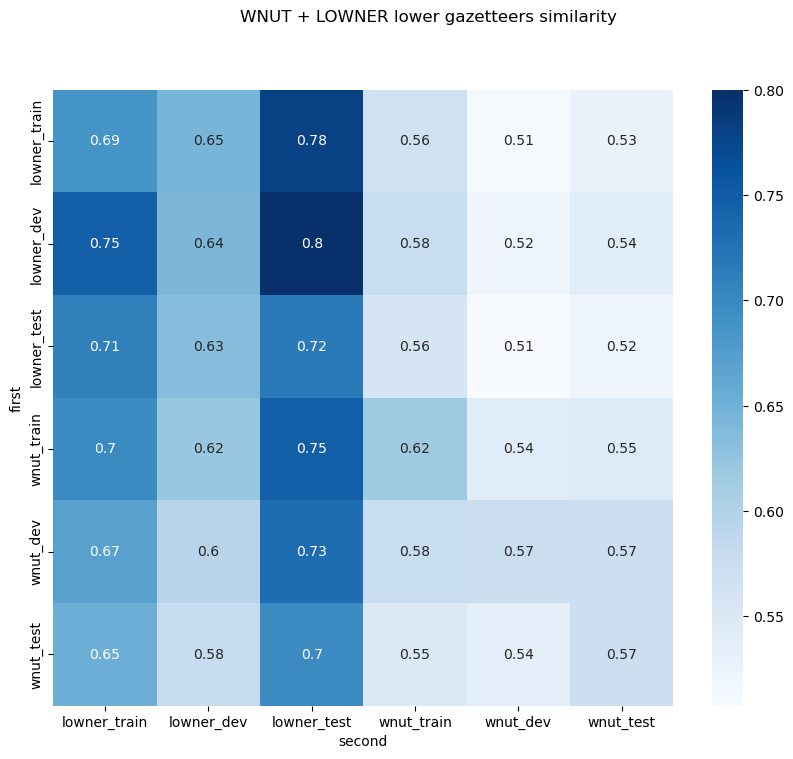

In [2]:
from data_similarity.summary import visualize_similarity_data
import matplotlib.pyplot as plt
import os
import pandas as pd

thesis_path = "/home/loebbert/projects/thesis"

wnut_lowner_sim.to_csv(os.path.join(thesis_path, "data_similarity",
                                    "wnut_lowner_sim_lower.csv"),
                        sep=";",
                        decimal=",")

wnut_lowner_sim = pd.read_csv(os.path.join(thesis_path, "data_similarity",
                                           "wnut_lowner_sim_lower.csv"),
                              sep=";",
                              decimal=",")

plt.figure(figsize=(10, 8))
plot = visualize_similarity_data(wnut_lowner_sim, "sentences")
plot.suptitle("WNUT + LOWNER lower sentences similarity")
plt.savefig(os.path.join(thesis_path, "data_similarity",
                            "wnut_lowner_sentences_lower.png"),
            dpi=150,
            format="png")

plt.close()
plt.figure(figsize=(10, 8))

plot = visualize_similarity_data(wnut_lowner_sim, "gazetteers")
plot.suptitle("WNUT + LOWNER lower gazetteers similarity")
plt.savefig(os.path.join(thesis_path, "data_similarity",
                            "wnut_lowner_gazetteers_lower.png"),
            dpi=150,
            format="png")

In [15]:
sents = wnut_lowner_sim.loc[wnut_lowner_sim["data_type"] == "sentences"].pivot_table(
    "cosine_similarity", index="first", columns="second")

sents.columns


Index(['lowner_dev', 'lowner_test', 'lowner_train', 'wnut_dev', 'wnut_test',
       'wnut_train'],
      dtype='object', name='second')

In [35]:
sents.columns.to_list()

['lowner_dev',
 'lowner_test',
 'lowner_train',
 'wnut_dev',
 'wnut_test',
 'wnut_train']

In [34]:
from functools import cmp_to_key
from locale import strcoll
import pandas as pd

def compare_dataset_names(a, b):
    scores = {"train": 0, "dev": 1, "test": 2}
    a1, a2 = a.split("_")
    b1, b2 = b.split("_")
    dataset_eq = strcoll(a1, b1)
    if dataset_eq != 0:
        return dataset_eq
    if a2 == b2:
        return 0
    return scores[a2] - scores[b2]

cols = [
    'lowner_dev', 'lowner_test', 'lowner_train', 'wnut_dev', 'wnut_test',
    'wnut_train'
]



cmp_dataset_names = cmp_to_key(compare_dataset_names)

cols.sort(key=cmp_dataset_names)
sents[cols].sort_index(level="first", key=lambda x: pd.Series([cols.index(y) for y in x]))

second,lowner_train,lowner_dev,lowner_test,wnut_train,wnut_dev,wnut_test
first,,,,,,
lowner_train,0.562071,0.509517,0.596655,0.345204,0.320629,0.331634
lowner_dev,0.565344,0.511339,0.597667,0.346598,0.322268,0.334780
lowner_test,0.564009,0.509999,0.596320,0.346344,0.321732,0.332018
wnut_train,0.389533,0.347447,0.413059,0.589967,0.391781,0.444992
wnut_dev,0.394597,0.355701,0.424611,0.402928,0.449162,0.374803
wnut_test,0.388376,0.350374,0.417166,0.411325,0.348079,0.458273


In [1]:
from itertools import combinations_with_replacement
list(combinations_with_replacement([
    'lowner_dev', 'lowner_test', 'lowner_train', 'wnut_dev', 'wnut_test',
    'wnut_train'
], 2))


[('lowner_dev', 'lowner_dev'),
 ('lowner_dev', 'lowner_test'),
 ('lowner_dev', 'lowner_train'),
 ('lowner_dev', 'wnut_dev'),
 ('lowner_dev', 'wnut_test'),
 ('lowner_dev', 'wnut_train'),
 ('lowner_test', 'lowner_test'),
 ('lowner_test', 'lowner_train'),
 ('lowner_test', 'wnut_dev'),
 ('lowner_test', 'wnut_test'),
 ('lowner_test', 'wnut_train'),
 ('lowner_train', 'lowner_train'),
 ('lowner_train', 'wnut_dev'),
 ('lowner_train', 'wnut_test'),
 ('lowner_train', 'wnut_train'),
 ('wnut_dev', 'wnut_dev'),
 ('wnut_dev', 'wnut_test'),
 ('wnut_dev', 'wnut_train'),
 ('wnut_test', 'wnut_test'),
 ('wnut_test', 'wnut_train'),
 ('wnut_train', 'wnut_train')]

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
first: 100%|██████████| 543/543 [00:00<00:00, 7184.59it/s]


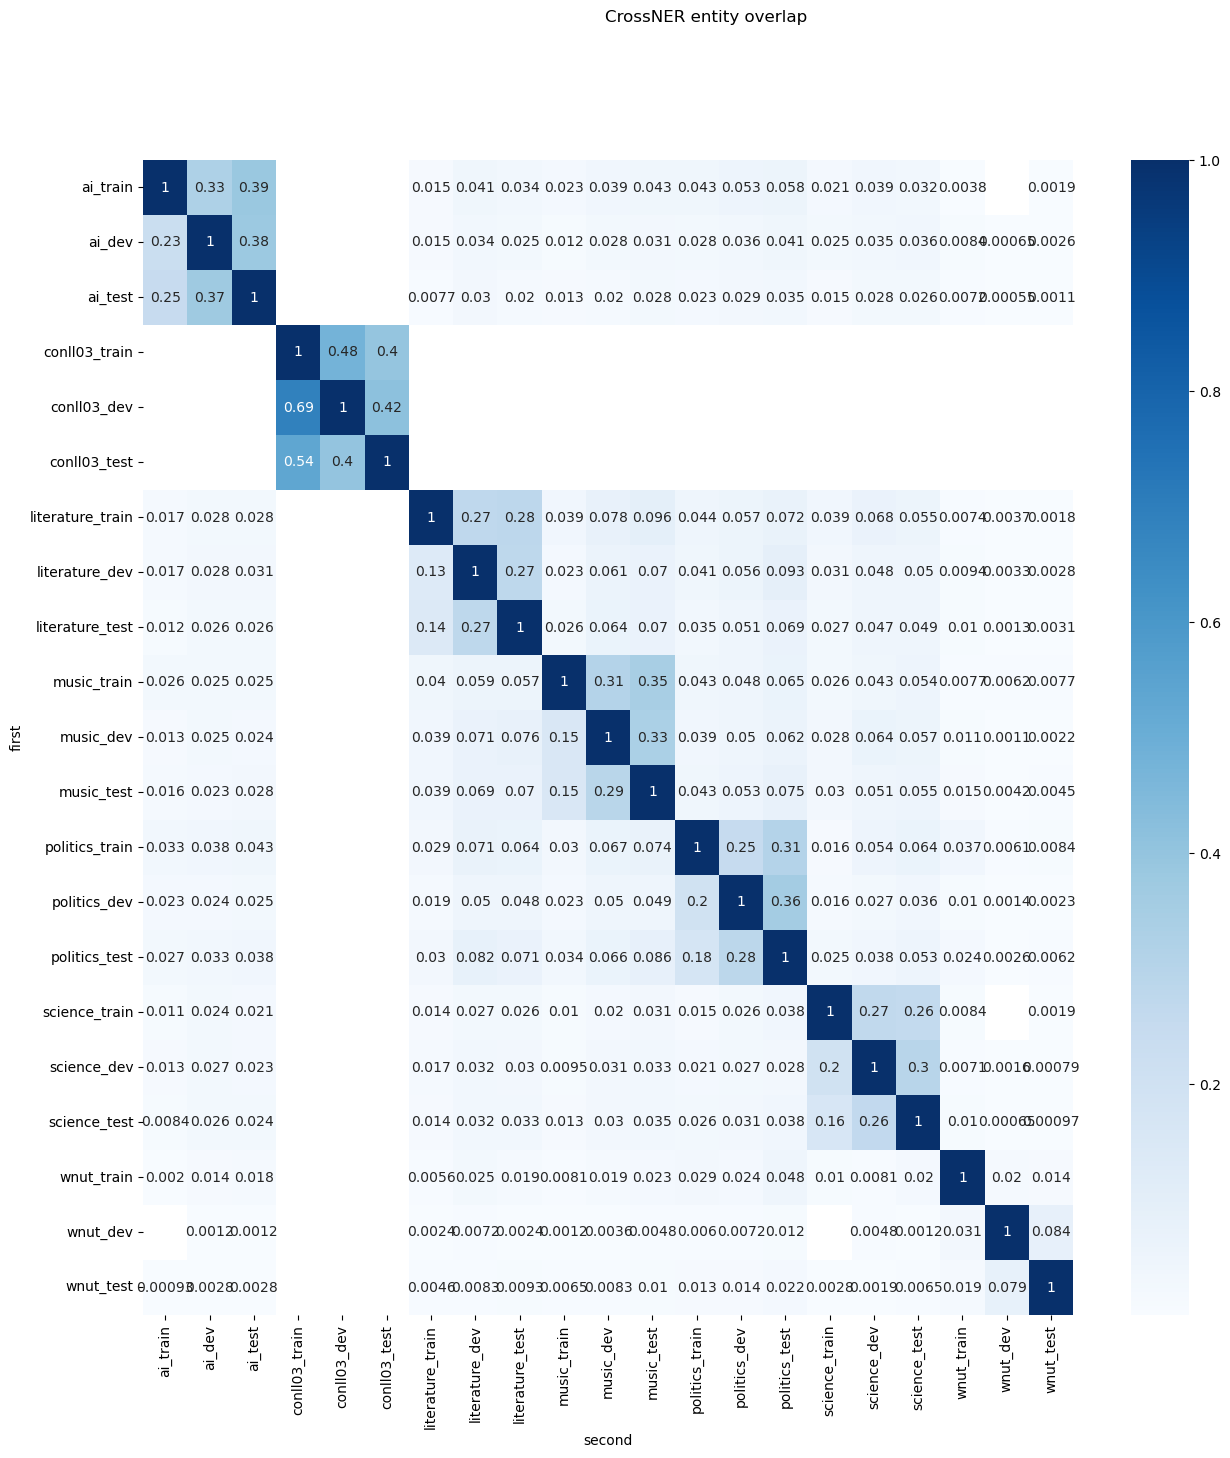

In [1]:
from data_similarity.summary import cross_ner

cross_ner()

first: 100%|██████████| 33661/33661 [02:51<00:00, 196.22it/s]


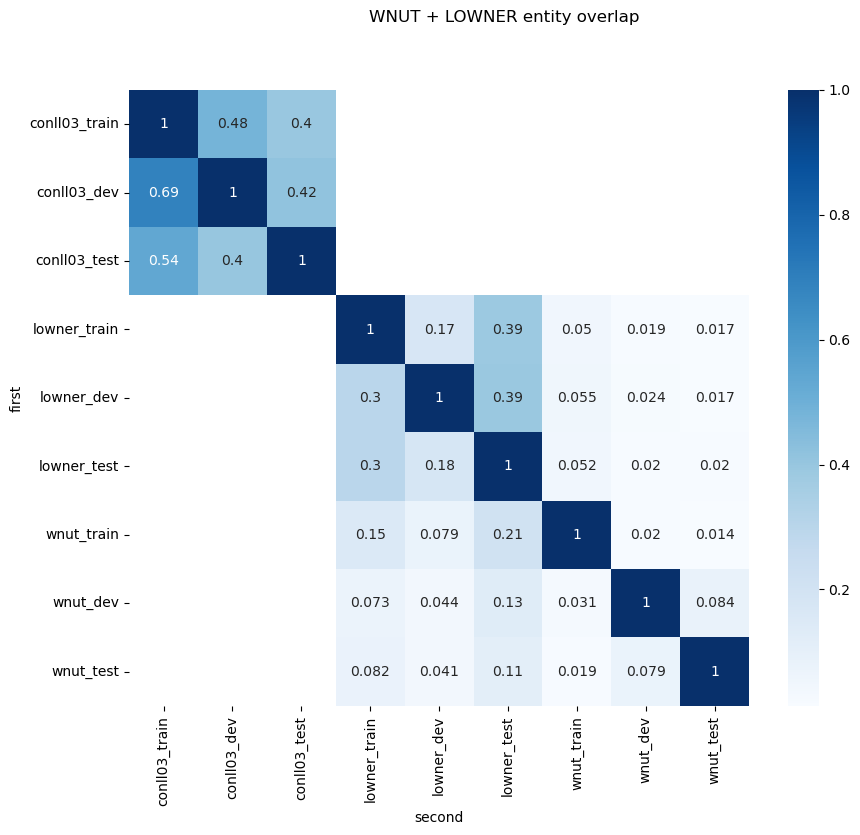

In [3]:
from data_similarity.summary import conll_lowner_wnut

conll_lowner_wnut()